In [1]:
# notebooks/03_model_training.ipynb
# 第一个单元格：基础配置
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# 字体设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ 模型训练环境准备完成")

✅ 模型训练环境准备完成


In [2]:
# 第二个单元格：加载特征数据
print("📂 加载特征数据...")

# 加载处理后的特征
features_df = pd.read_csv('../data/processed/features.csv')
feature_scores = pd.read_csv('../data/processed/feature_scores.csv')

print(f"📊 特征数据形状: {features_df.shape}")
print(f"📈 特征数量: {len(features_df.columns) - 1}")  # 减去target
print(f"🎯 样本数量: {len(features_df)}")

# 显示特征信息
print("\n🔍 特征预览:")
display(features_df.head())

print("\n📋 特征相关性排名:")
display(feature_scores.head(10))

# 检查数据平衡
target_distribution = features_df['target'].value_counts()
print(f"\n🎯 目标变量分布:")
print(f"   蓝色方胜利 (1): {target_distribution.get(1, 0):,} ({target_distribution.get(1, 0)/len(features_df)*100:.1f}%)")
print(f"   红色方胜利 (0): {target_distribution.get(0, 0):,} ({target_distribution.get(0, 0)/len(features_df)*100:.1f}%)")

📂 加载特征数据...
📊 特征数据形状: (51490, 16)
📈 特征数量: 15
🎯 样本数量: 51490

🔍 特征预览:


,tower_diff,dragon_diff,inhibitor_diff,baron_diff,red_gets_firstBlood,blue_gets_firstTower,red_gets_firstTower,blue_gets_firstDragon,red_gets_firstDragon,blue_gets_firstBaron,red_gets_firstBaron,blue_gets_firstInhibitor,red_gets_firstInhibitor,blue_gets_first_blood_and_tower,red_gets_first_blood_and_tower,target
0,6,2,1,2,1,1,0,1,0,1,0,1,0,0,0,1
1,8,2,4,0,0,1,0,1,0,0,0,1,0,1,0,1
2,6,0,1,1,1,1,0,0,1,1,0,1,0,0,0,1
3,9,2,2,1,0,1,0,1,0,1,0,1,0,1,0,1
4,6,2,2,1,1,1,0,1,0,1,0,1,0,0,0,1



📋 特征相关性排名:


,feature,score,p_value
0,tower_diff,185689.973866,0.0
1,inhibitor_diff,80142.682335,0.0
2,red_gets_firstInhibitor,58748.790427,0.0
3,blue_gets_firstInhibitor,56861.345214,0.0
4,dragon_diff,23839.373462,0.0
5,baron_diff,17049.734917,0.0
6,red_gets_firstBaron,11268.225623,0.0
7,red_gets_firstTower,10244.474979,0.0
8,blue_gets_firstTower,10148.225150,0.0
9,blue_gets_firstBaron,9064.862480,0.0



🎯 目标变量分布:
   蓝色方胜利 (1): 26,077 (50.6%)
   红色方胜利 (0): 25,413 (49.4%)


In [3]:
# 第三个单元格：数据准备和划分
from sklearn.model_selection import train_test_split

# 分离特征和目标
X = features_df.drop('target', axis=1)
y = features_df['target']

print(f"特征矩阵形状: {X.shape}")
print(f"目标变量形状: {y.shape}")

# 检查特征数据类型
print("\n📊 特征数据类型:")
print(X.dtypes.value_counts())

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\n🔧 数据标准化完成")
print(f"标准化后特征范围: [{X_scaled.min():.2f}, {X_scaled.max():.2f}]")
print(f"特征均值: {X_scaled.mean():.2f}, 标准差: {X_scaled.std():.2f}")

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("\n📋 数据划分结果:")
print(f"训练集: {X_train.shape[0]} 样本 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"测试集: {X_test.shape[0]} 样本 ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"训练集正样本比例: {y_train.mean():.3f}")
print(f"测试集正样本比例: {y_test.mean():.3f}")

特征矩阵形状: (51490, 15)
目标变量形状: (51490,)

📊 特征数据类型:
int64    15
Name: count, dtype: int64

🔧 数据标准化完成
标准化后特征范围: [-4.74, 5.46]
特征均值: -0.00, 标准差: 1.00

📋 数据划分结果:
训练集: 41192 样本 (80.0%)
测试集: 10298 样本 (20.0%)
训练集正样本比例: 0.506
测试集正样本比例: 0.506


In [5]:
# 第四个单元格：定义评估函数
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name=""):
    """评估模型性能"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
    
    # 训练模型
    model.fit(X_train, y_train)
    
    # 预测
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # 计算指标
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # ROC-AUC（如果模型支持）
    try:
        y_test_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_test_proba)
    except:
        test_auc = None
    
    # 结果字典
    results = {
        'model_name': model_name,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'test_auc': test_auc
    }
    
    # 打印结果
    print(f"\n📊 {model_name} 模型评估:")
    print("=" * 50)
    print(f"训练集准确率: {train_accuracy:.4f}")
    print(f"测试集准确率: {test_accuracy:.4f}")
    print(f"训练集精确率: {train_precision:.4f}")
    print(f"测试集精确率: {test_precision:.4f}")
    print(f"训练集召回率: {train_recall:.4f}")
    print(f"测试集召回率: {test_recall:.4f}")
    print(f"训练集F1分数: {train_f1:.4f}")
    print(f"测试集F1分数: {test_f1:.4f}")
    if test_auc:
        print(f"测试集AUC: {test_auc:.4f}")
    
    return results, y_test_pred, y_test_proba if 'y_test_proba' in locals() else None

🎯 训练逻辑回归模型...

📊 逻辑回归 模型评估:
训练集准确率: 0.9636
测试集准确率: 0.9667
训练集精确率: 0.9591
测试集精确率: 0.9635
训练集召回率: 0.9694
测试集召回率: 0.9710
训练集F1分数: 0.9642
测试集F1分数: 0.9672
测试集AUC: 0.9950

📈 逻辑回归特征重要性（前10名）:


,feature,coefficient,abs_coefficient
0,tower_diff,8.522513,8.522513
3,baron_diff,0.565081,0.565081
13,blue_gets_first_blood_and_tower,-0.426082,0.426082
4,red_gets_firstBlood,-0.340491,0.340491
12,red_gets_firstInhibitor,0.318103,0.318103
14,red_gets_first_blood_and_tower,0.308209,0.308209
2,inhibitor_diff,-0.279000,0.279000
9,blue_gets_firstBaron,-0.232758,0.232758
11,blue_gets_firstInhibitor,-0.168811,0.168811
6,red_gets_firstTower,0.162955,0.162955


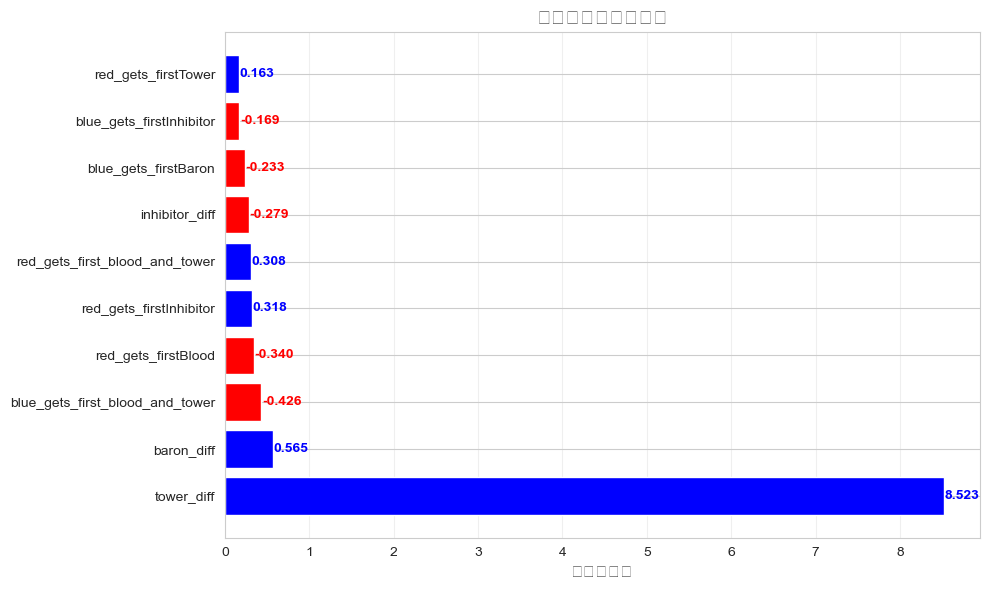

In [6]:
# 第五个单元格：基准模型 - 逻辑回归
from sklearn.linear_model import LogisticRegression

print("🎯 训练逻辑回归模型...")

# 创建逻辑回归模型
lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='lbfgs'
)

# 评估模型
lr_results, lr_pred, lr_proba = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "逻辑回归"
)

# 特征重要性（逻辑回归系数）
lr_coef = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0],
    'abs_coefficient': np.abs(lr_model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

print("\n📈 逻辑回归特征重要性（前10名）:")
display(lr_coef.head(10))

# 可视化特征重要性
plt.figure(figsize=(10, 6))
top_features = lr_coef.head(10)

colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['abs_coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('系数绝对值', fontsize=12)
plt.title('逻辑回归特征重要性', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top_features.iterrows()):
    color = 'red' if row['coefficient'] < 0 else 'blue'
    plt.text(row['abs_coefficient'] + 0.01, i, f'{row["coefficient"]:.3f}', 
             va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

🎯 训练决策树模型...

📊 决策树 模型评估:
训练集准确率: 0.9630
测试集准确率: 0.9653
训练集精确率: 0.9591
测试集精确率: 0.9621
训练集召回率: 0.9682
测试集召回率: 0.9697
训练集F1分数: 0.9636
测试集F1分数: 0.9659
测试集AUC: 0.9943

📈 决策树特征重要性（前10名）:


,feature,importance
0,tower_diff,0.984843
3,baron_diff,0.005933
2,inhibitor_diff,0.002314
12,red_gets_firstInhibitor,0.001858
6,red_gets_firstTower,0.001656
5,blue_gets_firstTower,0.001595
4,red_gets_firstBlood,0.000620
13,blue_gets_first_blood_and_tower,0.000602
11,blue_gets_firstInhibitor,0.000578
1,dragon_diff,0.000000


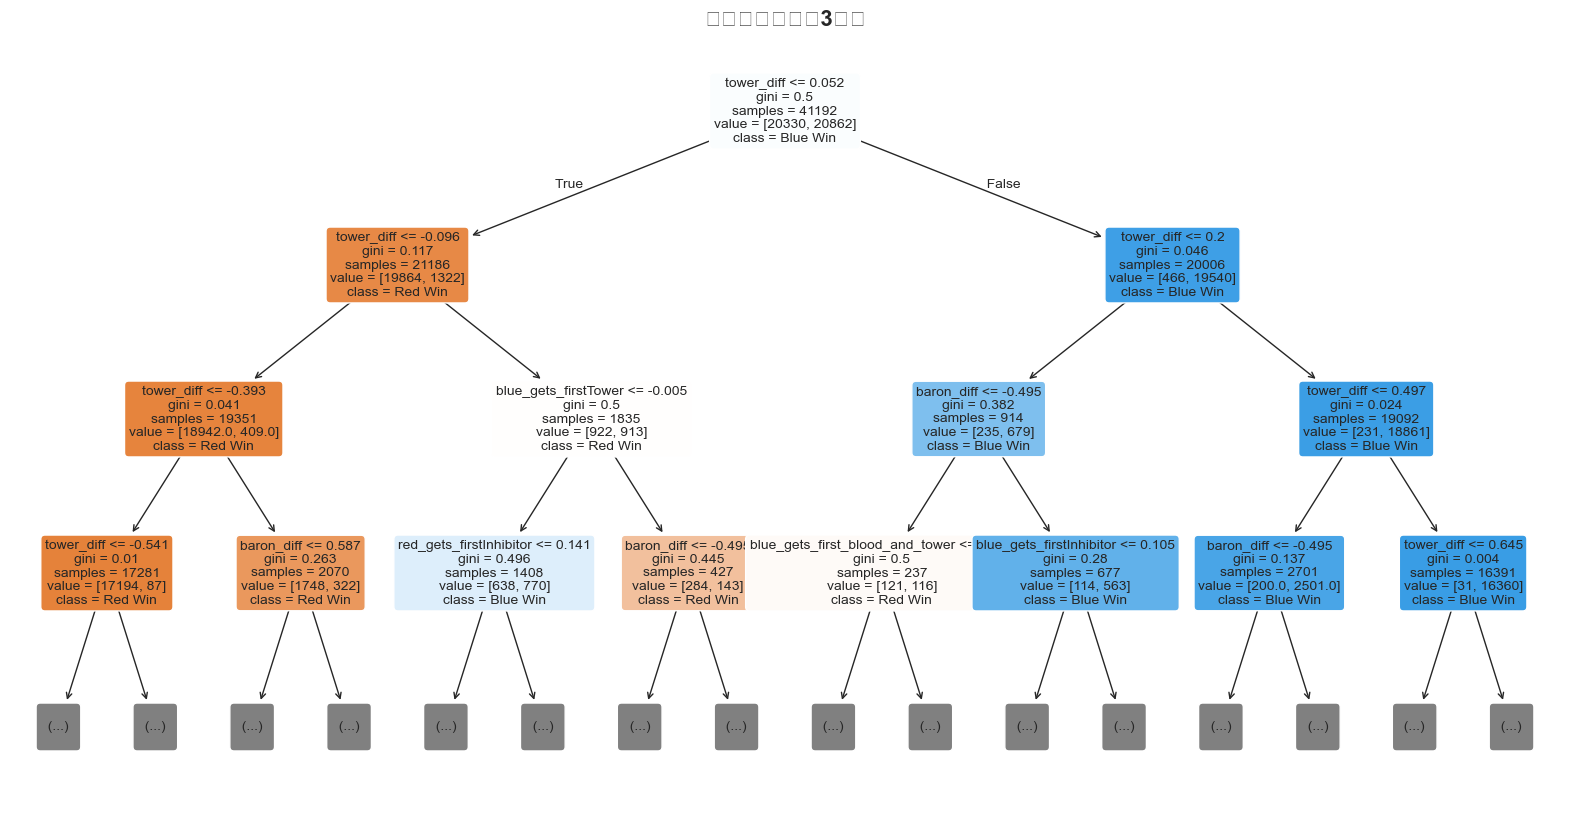

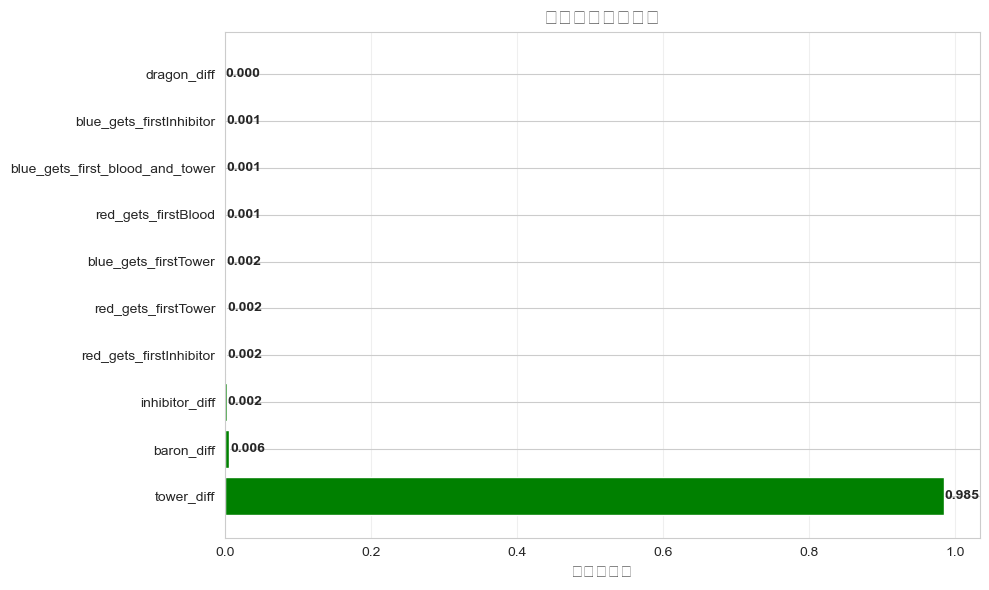

In [7]:
# 第六个单元格：决策树模型
from sklearn.tree import DecisionTreeClassifier, plot_tree

print("🎯 训练决策树模型...")

# 创建决策树模型
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # 限制深度防止过拟合
    min_samples_split=20,
    min_samples_leaf=10
)

# 评估模型
dt_results, dt_pred, dt_proba = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test, "决策树"
)

# 特征重要性
dt_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📈 决策树特征重要性（前10名）:")
display(dt_importance.head(10))

# 可视化决策树（部分）
plt.figure(figsize=(20, 10))
plot_tree(dt_model, 
          feature_names=X.columns,
          class_names=['Red Win', 'Blue Win'],
          filled=True, 
          rounded=True,
          max_depth=3,  # 只显示前3层
          fontsize=10)
plt.title('决策树结构（前3层）', fontsize=16, fontweight='bold')
plt.show()

# 特征重要性可视化
plt.figure(figsize=(10, 6))
top_dt_features = dt_importance.head(10)

plt.barh(range(len(top_dt_features)), top_dt_features['importance'], color='green')
plt.yticks(range(len(top_dt_features)), top_dt_features['feature'])
plt.xlabel('特征重要性', fontsize=12)
plt.title('决策树特征重要性', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top_dt_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

🎯 训练随机森林模型...

📊 随机森林 模型评估:
训练集准确率: 0.9673
测试集准确率: 0.9693
训练集精确率: 0.9634
测试集精确率: 0.9656
训练集召回率: 0.9723
测试集召回率: 0.9741
训练集F1分数: 0.9678
测试集F1分数: 0.9698
测试集AUC: 0.9960

📈 随机森林特征重要性（前10名）:


,feature,importance
0,tower_diff,0.359935
2,inhibitor_diff,0.200478
12,red_gets_firstInhibitor,0.157678
11,blue_gets_firstInhibitor,0.113484
3,baron_diff,0.047963
1,dragon_diff,0.041380
10,red_gets_firstBaron,0.022643
5,blue_gets_firstTower,0.019808
6,red_gets_firstTower,0.012121
9,blue_gets_firstBaron,0.008736


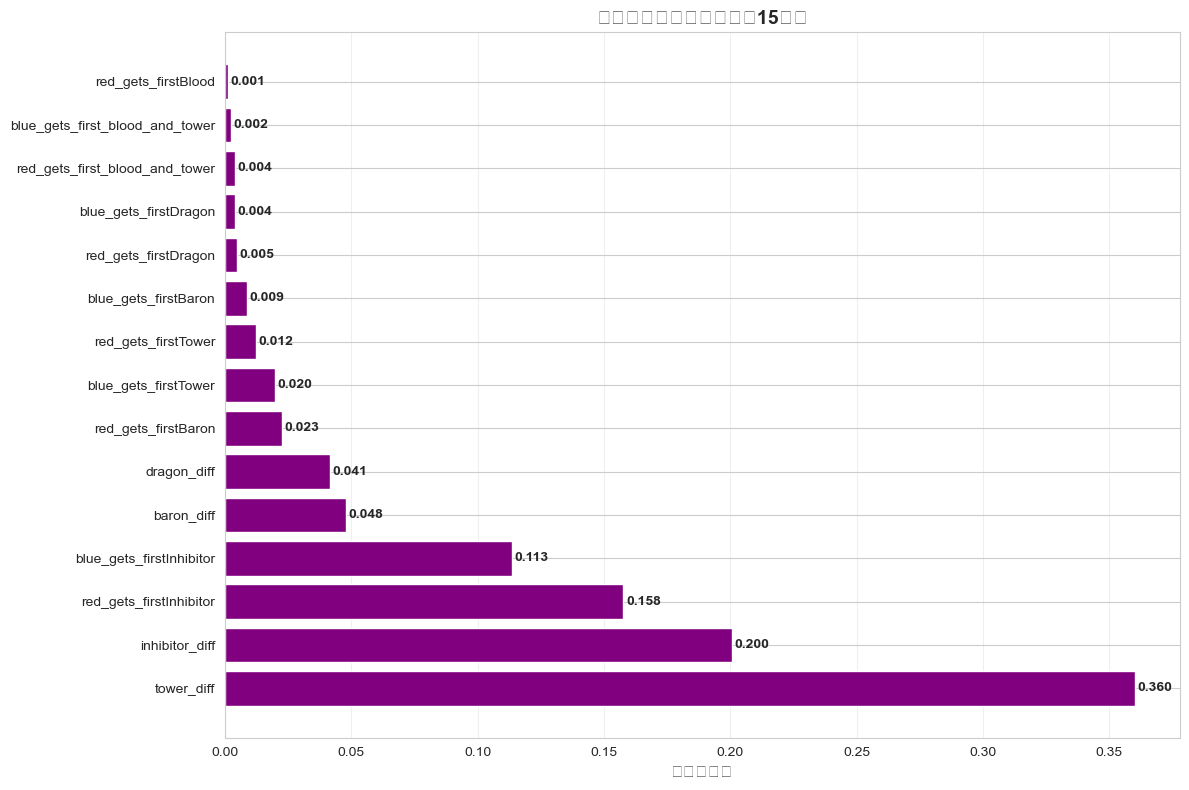

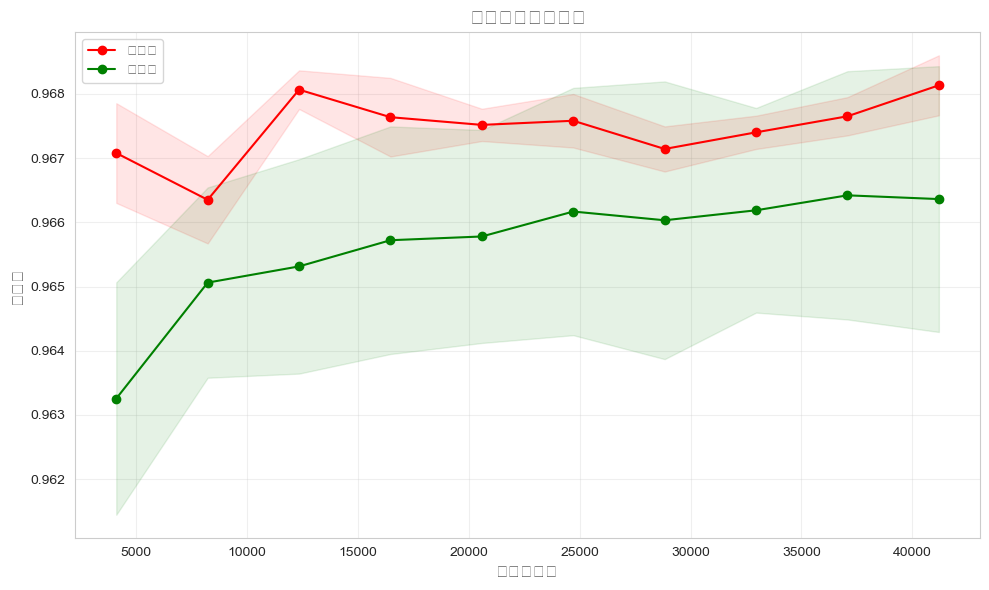

In [8]:
# 第七个单元格：随机森林模型
from sklearn.ensemble import RandomForestClassifier

print("🎯 训练随机森林模型...")

# 创建随机森林模型
rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    n_jobs=-1  # 使用所有CPU核心
)

# 评估模型
rf_results, rf_pred, rf_proba = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "随机森林"
)

# 特征重要性
rf_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📈 随机森林特征重要性（前10名）:")
display(rf_importance.head(10))

# 可视化特征重要性
plt.figure(figsize=(12, 8))
top_rf_features = rf_importance.head(15)

plt.barh(range(len(top_rf_features)), top_rf_features['importance'], color='purple')
plt.yticks(range(len(top_rf_features)), top_rf_features['feature'])
plt.xlabel('特征重要性', fontsize=12)
plt.title('随机森林特征重要性（前15名）', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top_rf_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 学习曲线
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_scaled, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='训练集')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='验证集')
plt.xlabel('训练样本数', fontsize=12)
plt.ylabel('准确率', fontsize=12)
plt.title('随机森林学习曲线', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

🎯 训练XGBoost模型...

📊 XGBoost 模型评估:
训练集准确率: 0.9710
测试集准确率: 0.9707
训练集精确率: 0.9674
测试集精确率: 0.9664
训练集召回率: 0.9756
测试集召回率: 0.9760
训练集F1分数: 0.9715
测试集F1分数: 0.9712
测试集AUC: 0.9962

📈 XGBoost特征重要性（前10名）:


,feature,importance
0,tower_diff,0.677597
2,inhibitor_diff,0.146229
6,red_gets_firstTower,0.046872
12,red_gets_firstInhibitor,0.025525
11,blue_gets_firstInhibitor,0.023827
3,baron_diff,0.014378
5,blue_gets_firstTower,0.012199
10,red_gets_firstBaron,0.009672
1,dragon_diff,0.009426
9,blue_gets_firstBaron,0.007888


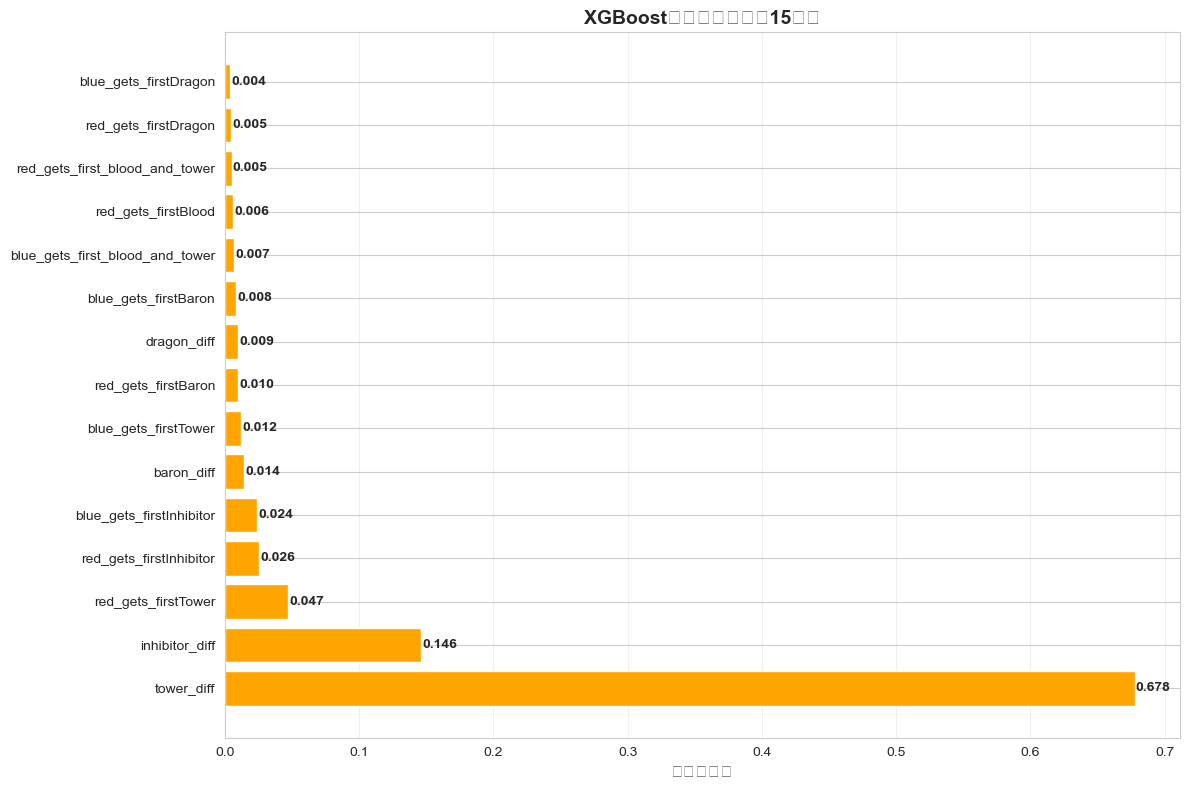

In [11]:
# 第八个单元格：XGBoost模型
from xgboost import XGBClassifier

print("🎯 训练XGBoost模型...")

# 创建XGBoost模型
xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

# 评估模型
xgb_results, xgb_pred, xgb_proba = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test, "XGBoost"
)

# 特征重要性
xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📈 XGBoost特征重要性（前10名）:")
display(xgb_importance.head(10))

# 可视化特征重要性
plt.figure(figsize=(12, 8))
top_xgb_features = xgb_importance.head(15)

plt.barh(range(len(top_xgb_features)), top_xgb_features['importance'], color='orange')
plt.yticks(range(len(top_xgb_features)), top_xgb_features['feature'])
plt.xlabel('特征重要性', fontsize=12)
plt.title('XGBoost特征重要性（前15名）', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

for i, (idx, row) in enumerate(top_xgb_features.iterrows()):
    plt.text(row['importance'] + 0.001, i, f'{row["importance"]:.3f}', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

📊 模型性能对比
模型性能对比表:


,模型,训练准确率,测试准确率,测试精确率,测试召回率,测试F1分数,测试AUC
0,逻辑回归,0.963585,0.966693,0.963470,0.971045,0.967243,0.995023
1,决策树,0.962954,0.965333,0.962139,0.969703,0.965906,0.994312
2,随机森林,0.967251,0.969314,0.965596,0.974113,0.969836,0.995953
3,XGBoost,0.971014,0.970674,0.966395,0.976031,0.971189,0.996210


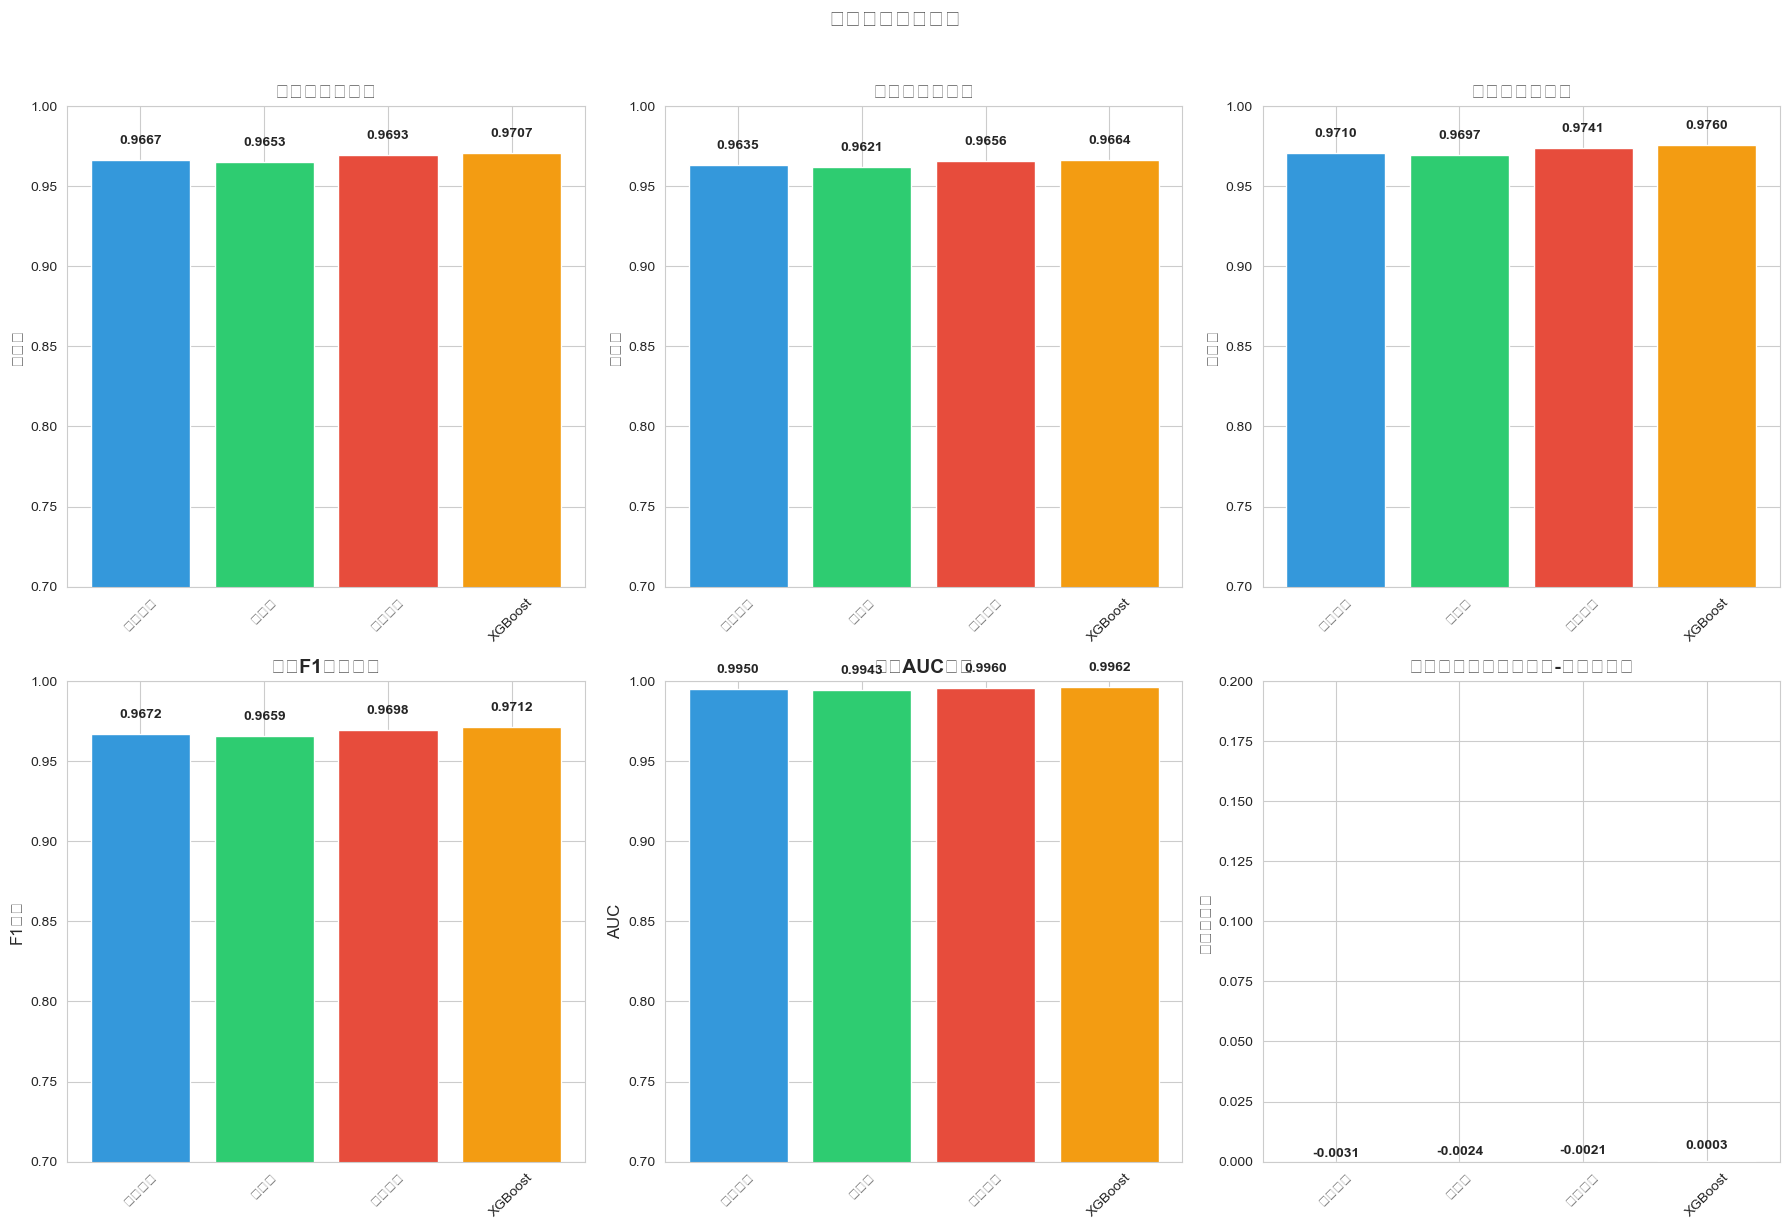


🏆 最佳模型:
模型: XGBoost
测试准确率: 0.9707
测试F1分数: 0.9712
测试AUC: 0.9962


In [12]:
# 第九个单元格：模型对比
print("📊 模型性能对比")
print("=" * 60)

# 收集所有模型结果
all_results = {
    '逻辑回归': lr_results,
    '决策树': dt_results,
    '随机森林': rf_results,
    'XGBoost': xgb_results
}

# 创建对比表格
comparison_df = pd.DataFrame({
    '模型': [r['model_name'] for r in all_results.values()],
    '训练准确率': [r['train_accuracy'] for r in all_results.values()],
    '测试准确率': [r['test_accuracy'] for r in all_results.values()],
    '测试精确率': [r['test_precision'] for r in all_results.values()],
    '测试召回率': [r['test_recall'] for r in all_results.values()],
    '测试F1分数': [r['test_f1'] for r in all_results.values()],
    '测试AUC': [r['test_auc'] if r['test_auc'] else np.nan for r in all_results.values()]
})

print("模型性能对比表:")
display(comparison_df)

# 可视化对比
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. 准确率对比
axes[0, 0].bar(comparison_df['模型'], comparison_df['测试准确率'], color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0, 0].set_title('测试准确率对比', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('准确率', fontsize=12)
axes[0, 0].set_ylim(0.7, 1.0)
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['测试准确率']):
    axes[0, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 2. 精确率对比
axes[0, 1].bar(comparison_df['模型'], comparison_df['测试精确率'], color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0, 1].set_title('测试精确率对比', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('精确率', fontsize=12)
axes[0, 1].set_ylim(0.7, 1.0)
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['测试精确率']):
    axes[0, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 3. 召回率对比
axes[0, 2].bar(comparison_df['模型'], comparison_df['测试召回率'], color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[0, 2].set_title('测试召回率对比', fontsize=14, fontweight='bold')
axes[0, 2].set_ylabel('召回率', fontsize=12)
axes[0, 2].set_ylim(0.7, 1.0)
axes[0, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['测试召回率']):
    axes[0, 2].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 4. F1分数对比
axes[1, 0].bar(comparison_df['模型'], comparison_df['测试F1分数'], color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1, 0].set_title('测试F1分数对比', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('F1分数', fontsize=12)
axes[1, 0].set_ylim(0.7, 1.0)
axes[1, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['测试F1分数']):
    axes[1, 0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 5. AUC对比（如果有）
if not comparison_df['测试AUC'].isna().all():
    axes[1, 1].bar(comparison_df['模型'], comparison_df['测试AUC'], color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
    axes[1, 1].set_title('测试AUC对比', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('AUC', fontsize=12)
    axes[1, 1].set_ylim(0.7, 1.0)
    axes[1, 1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(comparison_df['测试AUC']):
        if not np.isnan(v):
            axes[1, 1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 6. 过拟合程度对比（训练集-测试集差异）
overfit_diff = comparison_df['训练准确率'] - comparison_df['测试准确率']
axes[1, 2].bar(comparison_df['模型'], overfit_diff, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])
axes[1, 2].set_title('过拟合程度对比（训练-测试差异）', fontsize=14, fontweight='bold')
axes[1, 2].set_ylabel('准确率差异', fontsize=12)
axes[1, 2].set_ylim(0, 0.2)
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(overfit_diff):
    axes[1, 2].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.suptitle('模型性能综合对比', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 总结最佳模型
best_model_idx = comparison_df['测试准确率'].idxmax()
best_model = comparison_df.loc[best_model_idx]

print("\n🏆 最佳模型:")
print("=" * 40)
print(f"模型: {best_model['模型']}")
print(f"测试准确率: {best_model['测试准确率']:.4f}")
print(f"测试F1分数: {best_model['测试F1分数']:.4f}")
if not np.isnan(best_model['测试AUC']):
    print(f"测试AUC: {best_model['测试AUC']:.4f}")